forked from `pilot_biopython_MSA-Dmel_v3`

In [1]:
from Bio import AlignIO as BAIO
from Bio.AlignIO import MafIO as BAMafIO
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
from Bio import Seq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
import os

files = os.listdir('/ru-auth/local/home/ezheng/store/ucsc/dm6_multiz27way/maf')
files = [file for file in files if '.maf' in file[-4:]] # potentially overly clever way to just grab files ending in '.maf'

In [3]:
def make_MafIndices(files, chromosome = '2'):
    dictidx = {}
    
    wd = '/ru-auth/local/home/ezheng/store/ucsc/dm6_multiz27way/maf'
    for file in files:
        maf_basename = '.'.join(file.split('.')[:-1])
        maf_coord = maf_basename
        
        try:
            dictidx[maf_coord] = BAMafIO.MafIndex(f'{wd}/{maf_basename}.chr{chromosome}.mafidx',
                                     f'{wd}/{file}',
                                     f'dm6.chr{chromosome}')
        except ValueError:
            print(f'no chunks of {chromosome} in {maf_coord}')
        except TypeError:
            print(f'loaded no chunks of {chromosome} in {maf_coord}')
        else:
            print(f'{chromosome} is on {maf_coord}')
            
    return dictidx

In [4]:
chrs = ['2L', '2R', '3L', '3R', '4', 'X', 'Y', 'M']

In [5]:
dictidx = {}
for chrom in chrs:
    dictidx.update(make_MafIndices(files=files, chromosome=chrom))

loaded no chunks of 2L in chr2R
2L is on chr2L
loaded no chunks of 2L in chrY
loaded no chunks of 2L in chrX
loaded no chunks of 2L in chr3L
loaded no chunks of 2L in chr3R
loaded no chunks of 2L in chr4
loaded no chunks of 2L in chrM
2R is on chr2R
loaded no chunks of 2R in chr2L
loaded no chunks of 2R in chrY
loaded no chunks of 2R in chrX
loaded no chunks of 2R in chr3L
loaded no chunks of 2R in chr3R
loaded no chunks of 2R in chr4
loaded no chunks of 2R in chrM
loaded no chunks of 3L in chr2R
loaded no chunks of 3L in chr2L
loaded no chunks of 3L in chrY
loaded no chunks of 3L in chrX
3L is on chr3L
loaded no chunks of 3L in chr3R
loaded no chunks of 3L in chr4
loaded no chunks of 3L in chrM
loaded no chunks of 3R in chr2R
loaded no chunks of 3R in chr2L
loaded no chunks of 3R in chrY
loaded no chunks of 3R in chrX
loaded no chunks of 3R in chr3L
3R is on chr3R
loaded no chunks of 3R in chr4
loaded no chunks of 3R in chrM
loaded no chunks of 4 in chr2R
loaded no chunks of 4 in chr2

## load annotations, etc

In [6]:
import GTF
import pandas as pd
import re 

def filter_by(df, constraints):
    """Filter MultiIndex by sublevels."""
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]

pd.Series.filter_by = filter_by
pd.DataFrame.filter_by = filter_by

In [7]:
novelEBZ = GTF.dataframe('/ru-auth/local/home/ezheng/results/Dmel_MSannot/outputblat.gtf')

In [8]:
novelEBZ.iloc[0].transcript_id.split('_')[-1]

'mid1'

In [9]:
# declare some useful columns
novelEBZ = novelEBZ.assign(midid=lambda x: x.transcript_id.str.split('_').str[-1],
                exonid=lambda x: x.index,
                EBZid=lambda x: x.transcript_id.str.split('_').str[1],
#                unifiedid=lambda x:x.EBZid +'_'+ x.midid+'_'+x.exonid.astype(str)
                unifiedid=lambda x:x.EBZid +'_'+ x.midid          )

In [10]:
EBZannot = pd.read_csv('/ru-auth/local/home/ezheng/results/Dmel_MSannot/fin_strictproteins_classes.csv')

In [11]:
print(EBZannot.shape)
EBZannot.head()

(1065, 24)


,Unnamed: 0,sequence,EBZ_ID,length,ATG,datasets,Q-value_embryo,Q-value_PL,Q-value_dev-adult,Q-value_dev-embryo,...,sense,exonic,intronic,fiveUTR,threeUTR,EBZ_IDnew,annot,bestPEP,npep,class
0,0,VFCINTKKHSKNLIFSTAFTLQHKLISFEI,2,30,-1,embryo.dev-embryo.PL,0.003616,0.005282,NaN,0.002516,...,0,0,0,0,0,2.1,intergenic;,0.003331,1,intergenic short ORF;
1,1,LHSFHFRFRHFRRRSAAQTARWRTLSLHF,4,29,-1,embryo.dev-embryo.dev-adult,0.025621,NaN,0.071714,0.000347,...,0,0,0,0,0,4.1,antisense;,0.000332,3,antisense short ORF;
2,3,QLFWSTIVEREMHVTFRRTTCPLCRGMRYADKPT,9,34,11,dev-adult.embryo.PL,0.003633,0.072059,0.032179,NaN,...,0,0,0,0,0,9.1,intergenic;,0.004717,3,intergenic short ORF;
3,4,GSIIKSDKNMSRIRIP,10,16,9,embryo,0.004853,NaN,NaN,NaN,...,0,0,0,0,0,10.1,antisense;,0.006133,1,antisense short ORF;
4,5,RWLEVGHAKMQVRIAALCLVFGVTRVEGFPLNIQV,20,35,9,embryo,0.004044,NaN,NaN,NaN,...,0,0,0,0,0,20.1,antisense;,0.003641,3,antisense short ORF;


In [12]:
chrs

['2L', '2R', '3L', '3R', '4', 'X', 'Y', 'M']

In [13]:
# spaghetti code to subset to just uniquely-located ORF fragments

uniqueEBZ = (novelEBZ.pipe(
                lambda df: df[df.unifiedid.isin(
                                (novelEBZ.groupby('unifiedid').count().pipe(lambda df: df[df.seqname < 2]).index)
                             )])
             # and then throw out those we can't verify    
             .pipe(lambda df: df[df.EBZid.astype(float).isin(EBZannot.EBZ_IDnew)])
             .pipe(lambda df: df[df.seqname.isin(chrs)]) 
)

In [14]:
print(uniqueEBZ.shape)
uniqueEBZ.head()

(1299, 14)


,seqname,source,feature,start,end,score,strand,frame,gene_id,transcript_id,midid,exonid,EBZid,unifiedid
0,2L,BLAT,exon,16164145,16164234,100.00,+,None,EBZ_2.1_sets_embryo.dev-embryo_mid1,EBZ_2.1_sets_embryo.dev-embryo_mid1,mid1,0,2.1,2.1_mid1
1,3R,BLAT,exon,26757494,26757580,100.00,+,None,EBZ_4.1_sets_embryo.dev-embryo_mid1,EBZ_4.1_sets_embryo.dev-embryo_mid1,mid1,1,4.1,4.1_mid1
5,3R,BLAT,exon,6471394,6471495,100.00,+,None,EBZ_9.1_sets_embryo_mid1,EBZ_9.1_sets_embryo_mid1,mid1,5,9.1,9.1_mid1
6,3R,BLAT,exon,6992431,6992478,100.00,+,None,EBZ_10.1_sets_embryo_mid1,EBZ_10.1_sets_embryo_mid1,mid1,6,10.1,10.1_mid1
18,3R,BLAT,exon,11767939,11768043,100.00,+,None,EBZ_20.1_sets_embryo_mid1,EBZ_20.1_sets_embryo_mid1,mid1,18,20.1,20.1_mid1


In [15]:
(uniqueEBZ.start.astype(int) - uniqueEBZ.end.astype(int)).sort_values(ascending=False).describe()

count    1299.000000
mean     -131.297921
std       168.396616
min     -5243.000000
25%      -158.000000
50%       -98.000000
75%       -74.000000
max       -44.000000
dtype: float64

In [16]:
import warnings

In [17]:
def get_species_name(chromosome):
    pattern = '^([A-Za-z])+'
    
    return re.search(pattern, chromosome).group()

In [18]:
matlist.available_matrices

['benner6',
 'benner22',
 'benner74',
 'blosum100',
 'blosum30',
 'blosum35',
 'blosum40',
 'blosum45',
 'blosum50',
 'blosum55',
 'blosum60',
 'blosum62',
 'blosum65',
 'blosum70',
 'blosum75',
 'blosum80',
 'blosum85',
 'blosum90',
 'blosum95',
 'feng',
 'fitch',
 'genetic',
 'gonnet',
 'grant',
 'ident',
 'johnson',
 'levin',
 'mclach',
 'miyata',
 'nwsgappep',
 'pam120',
 'pam180',
 'pam250',
 'pam30',
 'pam300',
 'pam60',
 'pam90',
 'rao',
 'risler',
 'structure']

In [19]:
matlist.grant

{('A', 'A'): 215,
 ('A', 'C'): 61,
 ('A', 'E'): 130,
 ('A', 'F'): 38,
 ('A', 'H'): 134,
 ('A', 'I'): 114,
 ('A', 'L'): 89,
 ('A', 'N'): 192,
 ('A', 'O'): 55,
 ('A', 'P'): 107,
 ('A', 'Q'): 154,
 ('A', 'R'): 119,
 ('A', 'S'): 150,
 ('A', 'U'): 43,
 ('A', 'V'): 63,
 ('A', 'W'): 47,
 ('A', 'Y'): 121,
 ('C', 'C'): 215,
 ('C', 'E'): 66,
 ('C', 'F'): 10,
 ('C', 'L'): 20,
 ('C', 'O'): 21,
 ('C', 'P'): 46,
 ('C', 'R'): 35,
 ('C', 'S'): 103,
 ('C', 'U'): 17,
 ('C', 'V'): 23,
 ('C', 'W'): 17,
 ('C', 'Y'): 56,
 ('E', 'E'): 215,
 ('E', 'P'): 177,
 ('E', 'R'): 144,
 ('E', 'S'): 157,
 ('E', 'U'): 123,
 ('F', 'E'): 112,
 ('F', 'F'): 215,
 ('F', 'L'): 102,
 ('F', 'P'): 101,
 ('F', 'R'): 118,
 ('F', 'S'): 60,
 ('F', 'U'): 193,
 ('F', 'V'): 165,
 ('F', 'W'): 194,
 ('F', 'Y'): 62,
 ('G', 'A'): 170,
 ('G', 'C'): 45,
 ('G', 'E'): 150,
 ('G', 'F'): 75,
 ('G', 'G'): 215,
 ('G', 'H'): 175,
 ('G', 'I'): 159,
 ('G', 'L'): 108,
 ('G', 'N'): 173,
 ('G', 'O'): 93,
 ('G', 'P'): 122,
 ('G', 'Q'): 186,
 ('G', 'R'): 1

In [20]:
import Bio

def _revcmp_(seq):

    temp = seq.__dict__.copy()
    
    del temp['_seq'] # since we don't want to clobber the reversed seq!
    
    #return(type(seq))
    seq = seq.reverse_complement()
    seq.__dict__.update(temp)
    
    return (seq)

def revcmpMSA(MSA):
    temp = [_revcmp_(a) for a in MSA]
    
    return Bio.Align.MultipleSeqAlignment(temp)

In [21]:
def check_conservation(MSA, EBZid, strand, scoretype='identity', debug=False, **kwargs):
    
    validation='null'
    
    if strand == '-':
        MSA = revcmpMSA(MSA)
    elif strand == '+':
        pass
    else:
        raise ValueError(f'Invalid strand: {strand}')
    
    # first we find the reference
    ref_n_id = -1
    for n, entry in enumerate(MSA):
        if 'dm6' in entry.name:
            ref_n_id = n
            
    if ref_n_id is -1:
        # we didn't find dm6
        #return ({'dm':'vf - ref genome'})
        
        validation = 'vf - ref genome'
        return {'validation':validation}
    
    # now we translate the reference to sanity check that it matches?
    if len(EBZannot[EBZannot.EBZ_IDnew == EBZid].sequence.values) is not 1:
        raise ValueError(f'{EBZid}: canonical protein sequence not unique!')
    val_trans = Seq.Seq(EBZannot[EBZannot.EBZ_IDnew == EBZid].sequence.values[0])
    
    # some errors on occasion -- we protect find_best_coordinates to avoid excessive debugging
    try:
        ref_trans, shift = find_best_coordinates(MSAseq=MSA[ref_n_id].seq, refseq=val_trans)
    except ValueError as e:
        ref_trans = e.args[1]
        shift = 0
        if debug: print('expected ', val_trans, 'got ', ref_trans)
        validation = 'vf - trans'
        #print('expected ', val_trans, 'got ', MSA[ref_n_id].seq.ungap('-').translate())
        #return ({'dm':'vf - trans'})
    
    ref_DNA = MSA[ref_n_id].seq.ungap('-')
    #if '*' in ref_trans: raise ValueError #return ({'dm': 'vf stop'})
    
    output = {}
    # now we iterate through the MSAs
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for n, entry in enumerate(MSA):
            name = get_species_name(entry.name)
            DNA = entry.seq.ungap('-')
            
            DNA = _shift(DNA, shift) # shift DNA by value from find_best_coordinates
            protein = DNA.translate() 
            
            # pure identity score
            if scoretype is 'identity' and not debug:
                identity_align_score = pairwise2.align.globalxx(protein, ref_trans, score_only=True)
            elif debug and scoretype is 'identity':
                identity_align_score = pairwise2.align.globalxx(protein, ref_trans, one_alignment_only=True)
                if identity_align_score:
                    print(name)
                    print(pairwise2.format_alignment(*identity_align_score[0]))
                    identity_align_score = identity_align_score[0][2]

            # BLOSUM substitution score
            elif scoretype is 'blosum62':
                identity_align_score = matrix_score(protein, ref_trans, matlist.blosum62, **kwargs)
            elif scoretype is 'blosum40':
                identity_align_score = matrix_score(protein, ref_trans, matlist.blosum40, **kwargs)
            elif scoretype is 'nucleotide':
                identity_align_score = pairwise2.align.globalxx(DNA, ref_DNA, score_only=True)
                
            else: 
                # shouldn't happen -- unsupported scoretype
                raise ValueError(f'Unsupported scoretype: {scoretype}')

            if not identity_align_score: identity_score = 0
                # note that if no alignment results, an empty list gets returned
                # and that python casts empty lists as False, so this catches empty lists!!!
                # (otherwise I get an annoying type mismatch error on the following division)

            else: identity_score = identity_align_score / len(ref_trans)

            output[name] = identity_score
        
        if validation is 'null': validation='ok'
    #except BiopythonWarning:
    
    output['validation'] = validation
    return output

In [22]:
def nucleotide_conservation(MSA, EBZid, scoretype='identity', debug=False, strand=None):
    
    validation='null'
    
    if strand == '-':
        MSA = revcmpMSA(MSA)
    elif strand == '+':
        pass
    else:
        raise ValueError(f'Invalid strand: {strand}')
    
    # first we find the reference
    ref_n_id = -1
    for n, entry in enumerate(MSA):
        if 'dm6' in entry.name:
            ref_n_id = n
            
    if ref_n_id is -1:
        # we didn't find dm6
        #return ({'dm':'vf - ref genome'})
        
        validation = 'vf - ref genome'
        return {'validation':validation}
    
    ref_DNA = MSA[ref_n_id].seq.ungap('-')
    
    output = {}
    # now we iterate through the MSAs
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for n, entry in enumerate(MSA):
            name = get_species_name(entry.name)
            DNA = entry.seq.ungap('-')
               
            # pure identity score
            if scoretype is 'nucleotide':
                identity_align_score = pairwise2.align.globalxx(DNA, ref_DNA, score_only=True)
                
            else: 
                # shouldn't happen -- unsupported scoretype
                raise ValueError(f'Unsupported scoretype: {scoretype}')

            if not identity_align_score: identity_score = 0
                # note that if no alignment results, an empty list gets returned
                # and that python casts empty lists as False, so this catches empty lists!!!
                # (otherwise I get an annoying type mismatch error on the following division)

            else: identity_score = identity_align_score / len(ref_DNA)

            output[name] = identity_score
        
        if validation is 'null': validation='ok'
    #except BiopythonWarning:
    
    output['validation'] = validation
    return output

In [23]:
Seq.Seq('ABCDCCC').find('X')

-1

In [24]:
def stop_codon_conservation(MSA, EBZid, scoretype='stopcodon', debug=False, strand=None):
    
    validation='null'
    
    if strand == '-':
        MSA = revcmpMSA(MSA)
    elif strand == '+':
        pass
    else:
        raise ValueError(f'Invalid strand: {strand}')
    
    # first we find the reference
    ref_n_id = -1
    for n, entry in enumerate(MSA):
        if 'dm6' in entry.name:
            ref_n_id = n
            
    if ref_n_id is -1:
        # we didn't find dm6
        #return ({'dm':'vf - ref genome'})
        
        validation = 'vf - ref genome'
        return {'validation':validation}
    
    ref_DNA = MSA[ref_n_id].seq.ungap('-')
    
        # now we translate the reference to sanity check that it matches?
    if len(EBZannot[EBZannot.EBZ_IDnew == EBZid].sequence.values) is not 1:
        raise ValueError(f'{EBZid}: canonical protein sequence not unique!')
    val_trans = Seq.Seq(EBZannot[EBZannot.EBZ_IDnew == EBZid].sequence.values[0])
    
    # some errors on occasion -- we protect find_best_coordinates to avoid excessive debugging
    try:
        ref_trans, shift = find_best_coordinates(MSAseq=MSA[ref_n_id].seq, refseq=val_trans)
    except ValueError as e:
        ref_trans = e.args[1]
        shift = 0
        if debug: print('expected ', val_trans, 'got ', ref_trans)
        validation = 'vf - trans'
        #print('expected ', val_trans, 'got ', MSA[ref_n_id].seq.ungap('-').translate())
        #return ({'dm':'vf - trans'})
    
    output = {}
    # now we iterate through the MSAs
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for n, entry in enumerate(MSA):
            name = get_species_name(entry.name)
            DNA = entry.seq.ungap('-')
            
            DNA = _shift(DNA, shift) # shift DNA by value from find_best_coordinates
            DNA = DNA[9:] # keeping the leading N nts is especially problematic here
            protein = DNA.translate()
            
            # pure identity score
            if scoretype is 'stopcodon':
                identity_align_score = protein.find('*')
                
                if identity_align_score is -1: identity_align_score = len(ref_trans)
                
            else: 
                # shouldn't happen -- unsupported scoretype
                raise ValueError(f'Unsupported scoretype: {scoretype}')

            if not identity_align_score: identity_score = 0
                # note that if no alignment results, an empty list gets returned
                # and that python casts empty lists as False, so this catches empty lists!!!
                # (otherwise I get an annoying type mismatch error on the following division)

            else: 
                if len(ref_trans) is not 0:
                    identity_score = identity_align_score / len(ref_trans)
                else:
                    identity_score = 0
                    
            output[name] = identity_score
        
        if validation is 'null': validation='ok'
    #except BiopythonWarning:
    
    output['validation'] = validation
    return output

In [25]:
str(Seq.Seq('A'))

'A'

In [26]:
def matrix_score(protein, reference, matrix=matlist.blosum62, stops=None):
    # accepts a Biopython Seq.Seq, and a reference Seq.Seq
    # returns a score
    # I need to explicitly consider stop handling 
    # --> option 1 is to split and do many-to-many comparison
    # --> option 2 is to just drop stops and let the (implied) lack of gap penalty take care of things
    
    ref_trans = reference #Seq.Seq(reference, ExtendedIUPACProtein()) # cast string to Seq
    
    if stops == 'split':
        if '*' in protein: 
            protein = protein.split('*')
        else:
            protein = [protein] # this should force everything to be a list?

        if '*' in ref_trans: 
            ref_trans = ref_trans.split('*')
        else:
            ref_trans = [ref_trans] # this should force everything to be a list?
            
    elif stops == 'drop':
        if '*' in protein:
            protein = Seq.Seq(str(protein).replace('*',''))
            
        protein = [protein]
        
        if '*' in ref_trans:
            ref_trans = Seq.Seq(str(ref_trans).replace('*',''))
        
        ref_trans = [ref_trans]
    
    else:
        raise ValueError ('Did not specify how to handle stops!')
        
    count = []
    for i in protein:
        for j in ref_trans:
            #print(i)
            #print(type(i), type(ref_trans))
            sc = pairwise2.align.globaldx(i, j, matrix, score_only=True)
            #sc = pairwise2.align.globalxs(i, ref_trans, -10, -1, score_only=True)
            if sc: count.append(sc)
            # see below -- needed to avoid weirdness with surprise empty list
    blosum_score = sum(count)
    
    return blosum_score

In [27]:
def find_best_coordinates(*, MSAseq, refseq, n_flank = 9):
    # in -- sequence that flanks an ORF by N bp, N, reference sequence
    # out -- start and end that match reference (maybe also returning a flag if not exact match?)
    
    frames = {0: MSAseq.ungap('-').translate(),
              1: MSAseq.ungap('-')[1:-2].translate(),
              2: MSAseq.ungap('-')[2:-1].translate()}
    
    best_frame = (-1, 0, (0, 0))
    # frame, score, (start (codons), end (codons))
    
    for frame, fr_seq in frames.items():
        #print(frame, fr_seq)
        scores = pairwise2.align.localxs(fr_seq, refseq, -100, -100, one_alignment_only=True)[0]
        # we use a gap penalty here since presumably there shouldn't be a gap in the right ORF
        #print(scores) # DEBUG
        if scores[2] > best_frame[1]:
            best_frame = (frame, scores[2], (scores[3], scores[4]))
    
    #save = best_frame # DEBUG
    
    # convert end to end-based index vs start-based
    new_end = -(len(frames[best_frame[0]]) - best_frame[2][1])
    if new_end is 0: 
        # print(new_end, len(frames[best_frame[0]]), best_frame[2][1]) # DEBUG
        new_end = len(frames[best_frame[0]]) # needed to avoid getting 0:0 slice
    best_frame = (best_frame[0], best_frame[1], (best_frame[2][0], new_end))
    
    # now we validate those coordinates
    verification_trans = frames[best_frame[0]]
    verification_trans = verification_trans[best_frame[2][0]:best_frame[2][1]]
    if str(verification_trans) != str(refseq):
        print(f"expected {str(refseq)} got {str(verification_trans)}")
        raise ValueError(str(refseq), str(verification_trans),  best_frame[2])
    
    # # alternatively -- only use % match?
    # ver = pairwise2.align.localxx(str(refseq), str(verification_trans), score_only=True)
    # if not ver or ver < .9*len(refseq): # permissive -- only 90% match accepted for now
    #     print(f"expected {str(refseq)} got {str(verification_trans)}")
    #     raise ValueError(str(refseq), str(verification_trans), ver, best_frame[2])
    
    
    # and now we return the refseq happily (lol)
    #print(best_frame[0])
    return(verification_trans, best_frame[0])

def _shift(seq, frame):
    '''
    returns seq shifted by the frame
    0 -> no shift
    1 -> clip off 1
    2 -> clip off 2
    '''
    if frame == 0:
        return seq
    elif frame == 1:
        return seq[1:-2]
    elif frame == 2:
        return seq[2:-1]
    else: raise ValueError(f"invalid frame: {frame}")


In [30]:
# calculate identity score

resdict = {}
for i, entry in uniqueEBZ.iterrows():
    # TBD!!! GROUPING / SPLICING OF EXONS
    
    #print(entry)
    st = int(entry.start) - 1 -9
    en = int(entry.end) + 9
    ch = 'chr' + entry.seqname
    ez = float(entry.EBZid)
    strand = entry.strand
    #print(ch, st, en, ez)
    #check_conservation(dictidx[ch].get_spliced([st],[en]), ez)
    resdict[entry.unifiedid] = check_conservation(dictidx[ch].get_spliced([st],[en]), ez, strand)

expected TINVDQKKWKNFKLADPDFNKPGRIDLIIGADVYTHILQNGVIKIDGLLGQKTDFGWIVSGCKKSKGKETIVATTIEIKELDRYWEVEEEEKDDIESEICENKFIKTTKKDSDGRYIVSIPFKEDVTLGDSKKQAIARYMNLEKKLKRNEKLKVDYTKFMNEYMDLGHMIEVSDEGKYFLPHQAVIRDSSLTTKLRVVFDASAKTTNNKSLNDIMWVGPRVQKDIFDIIIKWRKWEFVVSADIEKMYRQIKIDNNDQKYQYILWRNSPKEKIKTYKLTTVTYGTASAPYLATRVLVDIADKCKNQVISAIIRNDFYMDDLMTGADSVEEANKLITLIPHELQKVGFNLRKWISNNSKILTTVEDTGDNKVLNIIENECVKTLGLKWEPQKDLFKFSVNCNDESKNINKRVVLSTLAKIFDPLGWLAPVTVSGKLFIQKLWINKSEWDQELSIEDKNYWEKYKENLLLLENIRIPRWINSNSSSVIQIHGFADASEKAYAAVVYAKVGPHVNIIASKSRVNPIKNRKTIPKLELCAAHLLSELIQRLKGSIDNIMEIYAWSDSTITLAWINSGQSKIKFIKRRTDDIRKLKNTEWNHVKSEDNPADLASRGVDSNQLINCDFWWKGPKWLADPKELWPRQQSVEEPVLINTVLNDKIDDPIYELIERYSSIEKLIRIIAYINRFVQMKTRNRAYSSIISVKEIRIAETVVIKKQQEYQFRQEIKCLKIKKEIKTNNKILSLNPFLDKDGVLRVGGRLQNSNAEFNVKHPIILEKCHLTSLLIKNAHKETLHGGINLMRNYIQRKYWIFGLKNSLKKYLRECVTCARYKQNTAQQIMGNLPKYRVTMTFPFLNTGIDYAGPYYVKCSKNRGQKTFKGYVAVFVCMATKAIHLEMVSDLTSDAFLAALRRFIARRGKCSNIYSDNGTNFVGAARKLDQELFNAIQENITIAAQLEKDRIDWHFIPPAGPHFGGIWEAGVKSMKYHLKRIIGDTI

expected HVSTVWFCQFAARTGRLNSENYECLAQR got HDSTVWFCQFAARTSRLNSPNYKYFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAVRTGLLNSENYECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAVRTGLLNSENYECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAAHTGRLNSENNECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAARTGRLNSENYECFAQR
expected SAIWQGGGLVREIVHGVGNQVGGHGHRLLELAPYVVGEGFMWLGFLLGHVAYSRILLMISKGNHERSLEIGLIKAGEGQSSRCRFKLGNRDPFGKIGHGILVGAAVIALKLSVQVGGEGHVQLVGVAGQKFLAGVEDVEVMGWIHRRGGHAVLLLALSADLAQGDLGLIDGQILGVQRYVLGVFQGFDQDLYGTGKTQVLRILQQCQNAEMVLLRAQRCGQAVVVVGGLDGVGG got 


KeyboardInterrupt: 

In [96]:
# calculate nucleotide identity score

DNAresdict = {}
for i, entry in uniqueEBZ.iterrows():
    # TBD!!! GROUPING / SPLICING OF EXONS
    
    #print(entry)
    st = int(entry.start) - 1 -9
    en = int(entry.end) + 9
    ch = 'chr' + entry.seqname
    ez = float(entry.EBZid)
    #print(ch, st, en, ez)
    #check_conservation(dictidx[ch].get_spliced([st],[en]), ez)
    strand = entry.strand
    DNAresdict[entry.unifiedid] = nucleotide_conservation(dictidx[ch].get_spliced([st],[en]),
                                                          ez, scoretype='nucleotide', strand=strand)

In [ ]:
# calculate stopcodon score

stopresdict = {}
for i, entry in uniqueEBZ.iterrows():
    # TBD!!! GROUPING / SPLICING OF EXONS
    
    #print(entry)
    st = int(entry.start) - 1 -9
    en = int(entry.end) + 9
    ch = 'chr' + entry.seqname
    ez = float(entry.EBZid)
    strand = entry.strand
    #print(ch, st, en, ez)
    #check_conservation(dictidx[ch].get_spliced([st],[en]), ez)
    stopresdict[entry.unifiedid] = stop_codon_conservation(dictidx[ch].get_spliced([st],[en]), ez, strand=strand)
    

In [31]:
identity_score_table = (
    pd.DataFrame.from_dict(resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
)

In [32]:
# single location per candidate
single_identity_score_table = (identity_score_table
    .dropna(how='all', axis='rows')
    .reset_index(['EBZid', 'midid'])
    .sort_values(by='midid', ascending=True)
    .drop_duplicates(subset='EBZid', keep='first')

    .sort_values(by='EBZid')
    .set_index(['EBZid', 'midid'], append=True)
     #.groupby('validation').mean()
     #.drop('vf - ref genome')
    #.filter_by({'dm':'vf - trans'})
)#.fillna(0).T.sort_values(by='ok', ascending = False)#.dm.value_counts()

In [97]:
DNAidentity_score_table = (
    pd.DataFrame.from_dict(DNAresdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
)

In [374]:
stop_score_table = (
    pd.DataFrame.from_dict(stopresdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
)

single_stop_score_table = (stop_score_table
    .dropna(how='all', axis='rows')
    .reset_index(['EBZid', 'midid'])
    .sort_values(by='midid', ascending=True)
    .drop_duplicates(subset='EBZid', keep='first')

    .sort_values(by='EBZid')
    .set_index(['EBZid', 'midid'], append=True)
)

## calculate similarity scores

In [93]:
# print BLOSUM40 score

BL40resdict = {}
for i, entry in uniqueEBZ.iterrows():
    # TBD!!! GROUPING / SPLICING OF EXONS
    
    #print(entry)
    st = int(entry.start) - 1 -9
    en = int(entry.end) + 9
    ch = 'chr' + entry.seqname
    ez = float(entry.EBZid)
    #print(ch, st, en, ez)
    #check_conservation(dictidx[ch].get_spliced([st],[en]), ez)
    strand = entry.strand
    BL40resdict[entry.unifiedid] = check_conservation(dictidx[ch].get_spliced([st],[en]), ez, scoretype='blosum40',
                                                      strand=strand, stops='drop')

expected TINVDQKKWKNFKLADPDFNKPGRIDLIIGADVYTHILQNGVIKIDGLLGQKTDFGWIVSGCKKSKGKETIVATTIEIKELDRYWEVEEEEKDDIESEICENKFIKTTKKDSDGRYIVSIPFKEDVTLGDSKKQAIARYMNLEKKLKRNEKLKVDYTKFMNEYMDLGHMIEVSDEGKYFLPHQAVIRDSSLTTKLRVVFDASAKTTNNKSLNDIMWVGPRVQKDIFDIIIKWRKWEFVVSADIEKMYRQIKIDNNDQKYQYILWRNSPKEKIKTYKLTTVTYGTASAPYLATRVLVDIADKCKNQVISAIIRNDFYMDDLMTGADSVEEANKLITLIPHELQKVGFNLRKWISNNSKILTTVEDTGDNKVLNIIENECVKTLGLKWEPQKDLFKFSVNCNDESKNINKRVVLSTLAKIFDPLGWLAPVTVSGKLFIQKLWINKSEWDQELSIEDKNYWEKYKENLLLLENIRIPRWINSNSSSVIQIHGFADASEKAYAAVVYAKVGPHVNIIASKSRVNPIKNRKTIPKLELCAAHLLSELIQRLKGSIDNIMEIYAWSDSTITLAWINSGQSKIKFIKRRTDDIRKLKNTEWNHVKSEDNPADLASRGVDSNQLINCDFWWKGPKWLADPKELWPRQQSVEEPVLINTVLNDKIDDPIYELIERYSSIEKLIRIIAYINRFVQMKTRNRAYSSIISVKEIRIAETVVIKKQQEYQFRQEIKCLKIKKEIKTNNKILSLNPFLDKDGVLRVGGRLQNSNAEFNVKHPIILEKCHLTSLLIKNAHKETLHGGINLMRNYIQRKYWIFGLKNSLKKYLRECVTCARYKQNTAQQIMGNLPKYRVTMTFPFLNTGIDYAGPYYVKCSKNRGQKTFKGYVAVFVCMATKAIHLEMVSDLTSDAFLAALRRFIARRGKCSNIYSDNGTNFVGAARKLDQELFNAIQENITIAAQLEKDRIDWHFIPPAGPHFGGIWEAGVKSMKYHLKRIIGDTI

expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAVRTGLLNSENYECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAVRTGLLNSENYECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAAHTGRLNSENNECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAARTGRLNSENYECFAQR
expected SAIWQGGGLVREIVHGVGNQVGGHGHRLLELAPYVVGEGFMWLGFLLGHVAYSRILLMISKGNHERSLEIGLIKAGEGQSSRCRFKLGNRDPFGKIGHGILVGAAVIALKLSVQVGGEGHVQLVGVAGQKFLAGVEDVEVMGWIHRRGGHAVLLLALSADLAQGDLGLIDGQILGVQRYVLGVFQGFDQDLYGTGKTQVLRILQQCQNAEMVLLRAQRCGQAVVVVGGLDGVGG got 
expected NFRYFVDELSFQSFLNTRAAKKKLVIFGRANKLGPIFLEPSDHYFFELKEKTNFIQVPPRFELGSQDSES got 
expected KGRLPVLHTPTVFFHQIRFIGVSSLTVIVSSAILDIPVIEPTCVRTLHPNINASTTHCLF got KGRLSVLHTPTVFFHQIRFIGVSSLTVIVSSAILDIPVIEPTCVRTLHPNINASTTHCLF
expected NSKREGLQFDFIRLSQISMMWQPEYNRKMYLGLCFTVCTAMTCRCQTPAYPGRQ got 
expected NSKREGLQFDFIRLSQISMMWQPEYNRKMYLGLCFTVCTAMTCRCQTPAYPGRQ got SKTEDLRYDSTRPCQMSIMWQPEYHRKVYLGRCFTAYTATTCLGQTLAYPGRQ
expected NSKREGLQFDFIRLSQISMMWQPEYNRKMYLGLCFTVCTAMTCRCQT

expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMVQGVSSTGEATLGLGPPLPATDSTD
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSWGEATLVLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DAMGQDVSSTGEATLGLGPPLPTTDSTD
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DAMGQDVSSTGEATLGLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSWGEATLVLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DAMGQDVSSTGEATLGLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSWGEATLVLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSTGEATLALGPLLPTTDCTRPARLQS
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSTGEATLALGPLLPTTDCTRPARLQS
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSTDEATLDLGPPLLTTDSTD
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSE

In [92]:
# print BLOSUM62 score

BL62resdict = {}
for i, entry in uniqueEBZ.iterrows():
    # TBD!!! GROUPING / SPLICING OF EXONS
    
    #print(entry)
    st = int(entry.start) - 1 -9
    en = int(entry.end) + 9
    ch = 'chr' + entry.seqname
    ez = float(entry.EBZid)
    #print(ch, st, en, ez)
    #check_conservation(dictidx[ch].get_spliced([st],[en]), ez)
    strand = entry.strand
    BL62resdict[entry.unifiedid] = check_conservation(dictidx[ch].get_spliced([st],[en]), ez, scoretype='blosum62',
                                                      strand=strand, stops='drop')
    
(pd.DataFrame.from_dict(BL62resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    .drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['validation'], append=True)
    #.set_index(['dm', 'validation'], append=True)
     .groupby('validation').mean()
    #.filter_by({'dm':'vf - trans'})
).dropna().T.sort_values(by='ok')#.dm.value_counts()

expected TINVDQKKWKNFKLADPDFNKPGRIDLIIGADVYTHILQNGVIKIDGLLGQKTDFGWIVSGCKKSKGKETIVATTIEIKELDRYWEVEEEEKDDIESEICENKFIKTTKKDSDGRYIVSIPFKEDVTLGDSKKQAIARYMNLEKKLKRNEKLKVDYTKFMNEYMDLGHMIEVSDEGKYFLPHQAVIRDSSLTTKLRVVFDASAKTTNNKSLNDIMWVGPRVQKDIFDIIIKWRKWEFVVSADIEKMYRQIKIDNNDQKYQYILWRNSPKEKIKTYKLTTVTYGTASAPYLATRVLVDIADKCKNQVISAIIRNDFYMDDLMTGADSVEEANKLITLIPHELQKVGFNLRKWISNNSKILTTVEDTGDNKVLNIIENECVKTLGLKWEPQKDLFKFSVNCNDESKNINKRVVLSTLAKIFDPLGWLAPVTVSGKLFIQKLWINKSEWDQELSIEDKNYWEKYKENLLLLENIRIPRWINSNSSSVIQIHGFADASEKAYAAVVYAKVGPHVNIIASKSRVNPIKNRKTIPKLELCAAHLLSELIQRLKGSIDNIMEIYAWSDSTITLAWINSGQSKIKFIKRRTDDIRKLKNTEWNHVKSEDNPADLASRGVDSNQLINCDFWWKGPKWLADPKELWPRQQSVEEPVLINTVLNDKIDDPIYELIERYSSIEKLIRIIAYINRFVQMKTRNRAYSSIISVKEIRIAETVVIKKQQEYQFRQEIKCLKIKKEIKTNNKILSLNPFLDKDGVLRVGGRLQNSNAEFNVKHPIILEKCHLTSLLIKNAHKETLHGGINLMRNYIQRKYWIFGLKNSLKKYLRECVTCARYKQNTAQQIMGNLPKYRVTMTFPFLNTGIDYAGPYYVKCSKNRGQKTFKGYVAVFVCMATKAIHLEMVSDLTSDAFLAALRRFIARRGKCSNIYSDNGTNFVGAARKLDQELFNAIQENITIAAQLEKDRIDWHFIPPAGPHFGGIWEAGVKSMKYHLKRIIGDTI

expected HVSTVWFCQFAARTGRLNSENYECLAQR got HDSTVWFCQFAARTSRLNSPNYKYFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAVRTGLLNSENYECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAVRTGLLNSENYECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAAHTGRLNSENNECFAQR
expected HVSTVWFCQFAARTGRLNSENYECLAQR got HVSTVWFCQFAARTGRLNSENYECFAQR
expected SAIWQGGGLVREIVHGVGNQVGGHGHRLLELAPYVVGEGFMWLGFLLGHVAYSRILLMISKGNHERSLEIGLIKAGEGQSSRCRFKLGNRDPFGKIGHGILVGAAVIALKLSVQVGGEGHVQLVGVAGQKFLAGVEDVEVMGWIHRRGGHAVLLLALSADLAQGDLGLIDGQILGVQRYVLGVFQGFDQDLYGTGKTQVLRILQQCQNAEMVLLRAQRCGQAVVVVGGLDGVGG got 
expected NFRYFVDELSFQSFLNTRAAKKKLVIFGRANKLGPIFLEPSDHYFFELKEKTNFIQVPPRFELGSQDSES got 
expected KGRLPVLHTPTVFFHQIRFIGVSSLTVIVSSAILDIPVIEPTCVRTLHPNINASTTHCLF got KGRLSVLHTPTVFFHQIRFIGVSSLTVIVSSAILDIPVIEPTCVRTLHPNINASTTHCLF
expected NSKREGLQFDFIRLSQISMMWQPEYNRKMYLGLCFTVCTAMTCRCQTPAYPGRQ got 
expected NSKREGLQFDFIRLSQISMMWQPEYNRKMYLGLCFTVCTAMTCRCQTPAYPGRQ got SKTEDLRYDSTRPCQMSIMWQPEYHRKVYLGRCFTAYTA

expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMVQGVSSTGEATLGLGPPLPATDSTD
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSWGEATLVLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DAMGQDVSSTGEATLGLGPPLPTTDSTD
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DAMGQDVSSTGEATLGLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSWGEATLVLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DAMGQDVSSTGEATLGLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSWGEATLVLGPPLPTTDSTV
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSTGEATLALGPLLPTTDCTRPARLQS
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSTGEATLALGPLLPTTDCTRPARLQS
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSES got DVMGQGVSSTDEATLDLGPPLLTTDSTD
expected DVMGQGVSSTGEATLGLRPPLLTTDPVRHARFFFSTPGSLFTFSVRPSE

validation,ok,vf - trans
triCas,1.747633,1.454693
apiMel,1.759738,1.277778
anoGam,1.881422,1.576582
musDom,1.994427,1.704911
droMoj,2.037822,1.364177
droAlb,2.086382,1.438343
droVir,2.094061,1.471038
droGri,2.119730,1.727910
droWil,2.167966,1.500185
droPer,2.359532,1.975517


In [94]:
blosum62_score_table = (

pd.DataFrame.from_dict(BL62resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    #.drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
    #.set_index(['dm', 'validation'], append=True)
    # .groupby('validation').mean()
    #.filter_by({'validation':'vf - trans'})
)#.fillna(0).mean().sort_values(ascending=False)

blosum62_score_table

,,,,,droBip,droPse,droMir,droTak,droYak,droGri,droWil,droAna,droPer,droBia,...,droSuz,droVir,droEle,droMoj,droEre,droAlb,triCas,musDom,anoGam,apiMel
,uniqueid,EBZid,midid,validation,,,,,,,,,,,,,,,,,,,,,
0,10.1_mid1,10.1,mid1,ok,NaN,NaN,NaN,2.000000,2.687500,1.625000,NaN,1.250000,NaN,1.500000,...,0.000000,NaN,2.125000,NaN,1.500000,1.812500,1.500000,NaN,NaN,NaN
1,100.1_mid1,100.1,mid1,ok,2.602410,NaN,NaN,1.927711,3.602410,NaN,NaN,2.313253,NaN,2.253012,...,2.240964,1.361446,2.710843,2.048193,2.301205,NaN,0.927711,NaN,NaN,NaN
2,1001.1_mid1,1001.1,mid1,ok,2.785714,2.071429,2.595238,2.857143,2.119048,1.809524,2.476190,2.833333,2.523810,2.642857,...,3.523810,1.023810,2.738095,1.952381,4.142857,NaN,1.571429,0.476190,1.904762,0.452381
3,1004.1_mid1,1004.1,mid1,ok,0.935484,1.064516,0.935484,2.193548,3.677419,NaN,NaN,1.129032,1.064516,2.806452,...,2.645161,NaN,2.000000,NaN,3.709677,NaN,0.161290,1.774194,NaN,NaN
4,101.1_mid1,101.1,mid1,ok,NaN,2.304348,2.275362,3.115942,3.318841,NaN,NaN,2.724638,2.304348,NaN,...,NaN,1.710145,3.347826,1.637681,4.043478,NaN,NaN,1.623188,NaN,NaN
5,1011.1_mid1,1011.1,mid1,ok,2.102941,1.779412,NaN,3.205882,1.779412,2.014706,1.250000,2.000000,2.323529,2.161765,...,1.720588,1.294118,1.382353,1.382353,2.117647,NaN,NaN,1.191176,NaN,NaN
6,1013.1_mid1,1013.1,mid1,ok,NaN,2.822222,1.955556,3.377778,2.666667,NaN,NaN,3.444444,NaN,1.688889,...,1.688889,NaN,2.288889,1.844444,2.800000,NaN,NaN,NaN,NaN,NaN
7,1015.1_mid1,1015.1,mid1,ok,0.620690,2.137931,2.137931,2.827586,2.413793,1.862069,0.620690,1.413793,2.137931,2.413793,...,2.517241,1.655172,1.931034,1.655172,2.793103,NaN,NaN,NaN,NaN,NaN
8,1016.1_mid1,1016.1,mid1,ok,NaN,NaN,NaN,NaN,NaN,NaN,2.684211,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.842105,3.052632,NaN,NaN


In [58]:
a = '''MEKWASLDSDESEPPAQENSCPDPPDRDPNSKPPPAKPHIFATRSRTRLFGKGDSEEASP
MDCPYEEGGLASCPIITVSSVVTLQRSVDGPTCLRQTSQDSVSTGVETPPRLYDRRSIFD
AVAQSNCQELESLLSFLQKSKKRLTDSEFKDPETGKTCLLKAMLNLHNGQNDTIALLLDI
ARKTDSLKQFVNASYTDSYYKGQTALHIAIERRNMALVTLLVENGADVQAAANGDFFKKT
KGRPGFYFGELPLSLAACTNQLAIVKFLLQNSWQPADISARDSVGNTVLHALVEVADNTA
DNTKFVTNMYNEILILGAKLHPTLKLEELTNKKGLTPLALAASSGKIGVLAYILQREIHE
PECRHLSRKFTEWAYGPVHSSLYDLSCIDTCEKNSVLEVIAYSSSETPNRHDMLLVEPLN
RLLQDKWDRFVKRIFYFNFFVYCLYMIIFTTAAYYRPVEGLPPYKLNNTVGDYFRVTGEI
LSVSGGVYFFFRGIQYFLQRRPSLKSLFVDSYSEILFFVQSLFMLVSVVLYFSHRKEYVA
SMVFSLAMGWTNMLYYTRGFQQMGIYAVMIEKMILRDLCRFMFVYLVFLFGFSTAVVTLI
EDGKNNSLPVESPPHKCRGSACRPGNSYNSLYSTCLELFKFTIGMGDLEFTENYDFKAVF
IILLLAYVILTYILLLNMLIALMGETVNKIAQESKNIWKLQRAITILDTEKSFLKCMRKA
FRSGKLLQVGFTPDGKDDFRWCFRVDEVNWTTWNTNVGIINEDPGNCEGVKRTLSFSLRS
GRVSGRNWKNFALVPLLRDASTRDRHSTQPEEVQLKHYTGSLKPEDAEVFKDSMAPGEK'''.replace('\n','')

b = '''MKKWSSTDLGAAADPLQKDTCPDPLDGDPNSRPPPAKPQLSTAKSRTRLFGKGDSEEAFP
VDCPHEEGELDSCPTITVSPVITIQRPGDGPTGARLLSQDSVAASTEKTLRLYDRRSIFE
AVAQNNCQDLESLLLFLQKSKKHLTDNEFKDPETGKTCLLKAMLNLHDGQNTTIPLLLEI
ARQTDSLKELVNASYTDSYYKGQTALHIAIERRNMALVTLLVENGADVQAAAHGDFFKKT
KGRPGFYFGELPLSLAACTNQLGIVKFLLQNSWQTADISARDSVGNTVLHALVEVADNTA
DNTKFVTSMYNEILMLGAKLHPTLKLEELTNKKGMTPLALAAGTGKIGVLAYILQREIQE
PECRHLSRKFTEWAYGPVHSSLYDLSCIDTCEKNSVLEVIAYSSSETPNRHDMLLVEPLN
RLLQDKWDRFVKRIFYFNFLVYCLYMIIFTMAAYYRPVDGLPPFKMEKTGDYFRVTGEIL
SVLGGVYFFFRGIQYFLQRRPSMKTLFVDSYSEMLFFLQSLFMLATVVLYFSHLKEYVAS
MVFSLALGWTNMLYYTRGFQQMGIYAVMIEKMILRDLCRFMFVYIVFLFGFSTAVVTLIE
DGKNDSLPSESTSHRWRGPACRPPDSSYNSLYSTCLELFKFTIGMGDLEFTENYDFKAVF
IILLLAYVILTYILLLNMLIALMGETVNKIAQESKNIWKLQRAITILDTEKSFLKCMRKA
FRSGKLLQVGYTPDGKDDYRWCFRVDEVNWTTWNTNVGIINEDPGNCEGVKRTLSFSLRS
SRVSGRHWKNFALVPLLREASARDRQSAQPEEVYLRQFSGSLKPEDAEVFKSPAASGEK'''.replace('\n','')

In [ ]:
(blosum62_score_table
).to_csv('~/temp/blosum62_score_table.csv')

In [46]:
blosum40_score_table=(pd.DataFrame.from_dict(BL40resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    #.drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
    #.set_index(['dm', 'validation'], append=True)
    # .groupby('validation').mean()
    #.filter_by({'validation':'vf - trans'})
)#.fillna(0).mean().sort_values(ascending=False)

In [ ]:
(blosum40_score_table
).to_csv('~/temp/blosum40_score_table.csv')

In [ ]:
(pd.DataFrame.from_dict(BL62resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    #.drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
    #.set_index(['dm', 'validation'], append=True)
    # .groupby('validation').mean()
    #.filter_by({'dm':'vf - trans'})
)

In [ ]:
(pd.DataFrame.from_dict(BL40resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    #.drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
    .replace('cons', 1)
    #.set_index(['dm', 'validation'], append=True)
    # .groupby('validation').mean()
    #.filter_by({'dm':'vf - trans'})
).divide(\
(pd.DataFrame.from_dict(resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    #.drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
    .replace(0, np.NaN)
    .replace('cons', 1)
    #.set_index(['dm', 'validation'], append=True)
    # .groupby('validation').mean()
    #.filter_by({'validation':'vf - trans'})
)).filter_by({'validation':'ok'}).fillna(0).mean().sort_values().mean()

In [ ]:
(pd.DataFrame.from_dict(BL62resdict, orient='index')
    .rename_axis('uniqueid')
    .reset_index()
   # .rename(columns={0:'uniqueid'})
    .assign(EBZid=lambda x: x.uniqueid.str.split('_').str[0],
            midid=lambda x: x.uniqueid.str.split('_').str[1])
    .sort_values(by=['EBZid', 'midid'])
    #.drop_duplicates(subset='EBZid', keep='first')
 
    .set_index(['uniqueid', 'EBZid', 'midid', 'validation'], append=True)
    .replace(0, np.NaN)
    .replace('cons', 1)
    #.set_index(['dm', 'validation'], append=True)
    .groupby('validation').mean()
    .dropna().T
    .sort_values(by='ok', ascending=False)
)

In [202]:
single_blosum62_score_table = (blosum62_score_table
    .dropna(how='all', axis='rows')
    .reset_index(['EBZid', 'midid'])
    .sort_values(by='midid', ascending=True)
    .drop_duplicates(subset='EBZid', keep='first')

    .sort_values(by='EBZid')
    .set_index(['EBZid', 'midid'], append=True))

In [209]:
(single_blosum62_score_table
     .pipe(lambda df: df[df > 2.5])
     .count(axis=1)
     .sort_values(ascending=False)
)

      uniqueid      validation  EBZid   midid 
550   2205.1_mid1   ok          2205.1  mid1      27
731   2654.1_mid1   ok          2654.1  mid1      26
142   1369.1_mid1   ok          1369.1  mid1      26
1191  716.1_mid1    ok          716.1   mid1      26
326   1678.1_mid1   ok          1678.1  mid1      25
873   3511.1_mid1   ok          3511.1  mid1      25
1039  466.1_mid1    ok          466.1   mid1      25
502   2067.1_mid1   ok          2067.1  mid1      25
821   3121.2_mid1   ok          3121.2  mid1      24
497   2054.1_mid1   ok          2054.1  mid1      24
190   1518.2_mid1   ok          1518.2  mid1      24
876   3581.1_mid1   ok          3581.1  mid1      24
906   386.2_mid1    ok          386.2   mid1      24
888   368.1_mid1    ok          368.1   mid1      24
1296  997.1_mid1    ok          997.1   mid1      24
504   2076.1_mid1   ok          2076.1  mid1      23
1058  4767.1_mid1   ok          4767.1  mid1      23
134   1343.1_mid1   ok          1343.1  mid1      23

## manual alignment review

In [875]:
import Bio

def fast_print_align(seq1, seq2, name1='', name2='', width=50):
    #name1=''
    #name2=''
    
    if type(seq1) is Bio.SeqRecord.SeqRecord and type(seq2) is Bio.SeqRecord.SeqRecord:
        name1 = seq1.name
        name2 = seq2.name

        seq1 = seq1.seq
        seq2 = seq2.seq
    
    if len(seq1) != len(seq2): raise ValueError
    
    comparison = ''
    
    starts = []
    ends = []
    last_pos_is_gap = True
    for i in range(0,len(seq1)):
        if seq1[i] is seq2[i]:
            comparison += '|'
        else: 
            comparison += ' '
        
        curr_pos_is_gap = (seq1[i] is '-') and (seq2[i] is '-')
        
        if not curr_pos_is_gap and last_pos_is_gap:
        # if both are NOT gaps AND the last position is a gap
            # we have swapped from gap stretch to not gap stretch
            starts.append(i)
            last_pos_is_gap = False
            
        elif curr_pos_is_gap and not last_pos_is_gap:
        # if 
                # we have swapped from not gap stretch to gap stretch
            ends.append(i)
            last_pos_is_gap = True
            
            # other 2 possibilities should be no-ops    
    
    # needed in case we end with a non-gap
    curr_pos_is_gap = (seq1[len(seq1)-1] is '-') and (seq2[len(seq2)-1] is '-')
    if not curr_pos_is_gap: ends.append(len(seq1))
    
    #print(len(starts), starts, len(ends), ends)
    #print(seq1, comparison, seq2, sep='\n')
        
    trimmed_sq1 = ''
    trimmed_cmp = ''
    trimmed_sq2 = ''
    
    #print(len(starts), len(ends))
    
    for bds in zip(starts,ends):
        trimmed_sq1 += seq1[bds[0]:bds[1]]
        trimmed_cmp += comparison[bds[0]:bds[1]]
        trimmed_sq2 += seq2[bds[0]:bds[1]]
        #print(seq1[bds[0]:bds[1]],comparison[bds[0]:bds[1]],seq2[bds[0]:bds[1]])
    
    for i in range(0, len(trimmed_sq1)//width + 1):
        print(trimmed_sq1[i*width:(i+1)*width],' ', name1, '\n',
              trimmed_cmp[i*width:(i+1)*width],            '\n',
              trimmed_sq2[i*width:(i+1)*width],' ', name2, '\n',
              sep='')
    #print(trimmed_sq1, trimmed_cmp, trimmed_sq2, sep='\n')

In [131]:
fast_print_align('PKSLLYHFHFENRREHTKHTCENVPGVGIILWPGEGPSGLQAFGQ',
                 'PEGLKAPHPATK*SQHPAHSHMCVLCVLCDSRSENGIVGIWVREX',
                name1='dm6',
                name2='droSim1')

PKSLLYHFHFENRREHTKHTCENVPGVGIILWPGEGPSGLQAFGQ dm6
|  |           |  |    |  |        |  |      
PEGLKAPHPATK*SQHPAHSHMCVLCVLCDSRSENGIVGIWVREX droSim1



In [132]:
fast_print_align('---SR-SKFMIHTWQR---------E-----------G-KCRWTTL-RNHLS-------S-E----CP-T-TYRFARAELCNA-----HLGILGAINKTGNCCRRCQVSKTA',
                'HN*SRW-KFMIHTWQRAGNVGGLL*ETISQVNVQPLIGL------LV---LSYAMPIWESLEP*IR-PETV----A-A----AVRSVK-L-------------RRC------',
                name1='dm6',
                name2='droSim1')

---SR-SKFMIHTWQR---------E-----------G-KCRWTTL-RNH dm6
   ||  |||||||||         |           |       |    
HN*SRW-KFMIHTWQRAGNVGGLL*ETISQVNVQPLIGL------LV--- droSim1

LS-------S-E----CP-T-TYRFARAELCNA-----HLGILGAINKTG dm6
||       | |     | |     | |    |      |          
LSYAMPIWESLEP*IR-PETV----A-A----AVRSVK-L---------- droSim1

NCCRRCQVSKTA dm6
   |||      
---RRC------ droSim1



## tree topology

In [31]:
from Bio import Phylo
from io import StringIO

In [32]:
tree = '''(((((((((((((((((dm:0.054203,
                (droSim:0.02131,
                droSec:0.022797):0.024262):0.058501,
               (droYak:0.088966,
               droEre:0.077153):0.025438):0.181996,
              (droBia:0.126739,
              droSuz:0.093422):0.096476):0.012539,
             (droAna:0.132676,
             droBip:0.134892):0.531515):0.002641,
            droEug:0.318569):0.036977,
           droEle:0.207426):0.00256,
          droKik:0.485329):0.00244,
         droTak:0.226746):0.014351,
        droRho:0.195624):0.049591,
       droFic:0.257704):0.290027,
      ((droPse:0.013853,
       droPer:0.014979):0.009699,
      droMir:0.017285):0.398344):0.150107,
     droWil:0.550935):0.041827,
    (((droVir:0.242786,
      droMoj:0.321598):0.090819,
     droAlb:0.436249):0.014378,
    droGri:0.318782):0.162991):0.222902,
   musDom:0.772795):0.268197,
  anoGam:1.14709):0.387299,
 apiMel:0.865834):0.588712,
triCas:0.588712);'''

tree = Phylo.read(StringIO(tree), 'newick')

In [90]:
def lookup_by_names(tree):
    names = {}
    for clade in tree.find_clades():
        if clade.name:
            if clade.name in names:
                raise ValueError("Duplicate key: %s" % clade.name)
            names[clade.name] = clade
    return names

In [91]:
tips = lookup_by_names(tree)

In [215]:
thres = .5

names = (identity_score_table.iloc[1].fillna(0).sort_values(ascending=True)
    .pipe(lambda s: s[s > thres]).index.values)

for i in names:
    pass

In [592]:
def applyable_monophyletic(series, func, tree, thres):
    #thres = .5

    names = (series[series > thres]).index.values
    
    return(func(tree,names))


def is_exactly_monophyletic(tree, species):
    # returns true iff input species are all the descendents of the LCA
    
    lca = tree.common_ancestor(species)
    subtree = tree.from_clade(lca)
    
    st_descendents = [i.name for i in subtree.find_clades(terminal=True)]
    # list comprehension to pull all the terminal names
    
    #print(species)
    #print(st_descendents)
    #print('---')
    try: 
        assert set(st_descendents) >= set(species) # we should have gotten back the original species
    except:
        print(species)
        print(st_descendents)
        raise ValueError
    
    return set(st_descendents) == set(species)

def missing_monophyletic(tree, species):
    # returns missing species iff input species are all the descendents of the LCA
    
    lca = tree.common_ancestor(species)
    subtree = tree.from_clade(lca)
    
    st_descendents = [i.name for i in subtree.find_clades(terminal=True)]
    # list comprehension to pull all the terminal names
    
    #print(species)
    #print(st_descendents)
    #print('---')
    try: 
        assert set(st_descendents) >= set(species) # we should have gotten back the original species
    except:
        print(species)
        print(st_descendents)
        raise ValueError
    
    if set(st_descendents) != set(species):
        return set(st_descendents) - set(species)
    else: return False
    
def depth(tree, species):
    # returns depth of the LCA (?)
    
    lca = tree.common_ancestor(species)
    return tree.depths()[lca]
    
def present_monophyletic(tree, species):
    # returns present species that are descendents of the LCA
    # structure parallels the other real functions (e.g. missing_monophyletic, hence why it looks stupid)
    
    return set(species)

In [972]:
def oldest_extant_relative(tree, species):
    reforder = ['dm', 'droSim', 'droSec', 'droYak',
       'droEre', 'droBia', 'droSuz',
       'droAna', 'droBip', 'droEug',
       'droEle', 'droKik', 'droTak',
       'droRho', 'droFic', 'droPse',
       'droPer', 'droMir', 'droWil',
       'droVir', 'droMoj', 'droAlb',
       'droGri', 
       'musDom', 'anoGam', 'apiMel', 'triCas']
    
    present = [sp for sp in reforder if sp in species]
    #return present[0]
    #print(present)
    
    # needed in case species is empty
    if len(present) > 0:
        return present[-1]
    else: return None

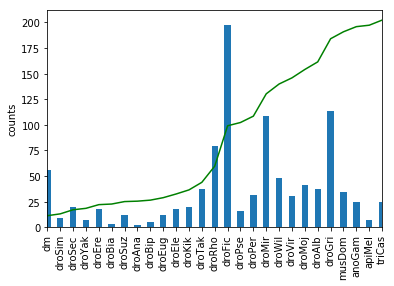

In [1015]:
thres = 2.5

furthest = pd.DataFrame(
    {'furthest':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(oldest_extant_relative, tree, thres)),
}
)

furthest.furthest.value_counts()[speciesorder].plot.bar()
furthest.furthest.value_counts()[speciesorder].cumsum().divide(5).plot.line(color='green')
plt.ylabel('counts')
plt.xticks(rotation=90)
plt.show()

In [830]:
thres = 2.5

monophyletic = pd.DataFrame(
    {'monophyletic':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(is_exactly_monophyletic, tree, thres)),
    'missingspecies':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(missing_monophyletic, tree, thres)),
    'presentspecies':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(present_monophyletic, tree, thres))}
)

## back to similarity analysis

In [250]:
thres = 2
monophyletic_blosum = pd.DataFrame(
    {'monophyletic':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(is_exactly_monophyletic, tree, thres)),
    'missingspecies':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(missing_monophyletic, tree, thres)),
    'presentspecies':single_blosum62_score_table
                     .fillna(0)
                     .apply(applyable_monophyletic, axis='columns', 
                            args=(present_monophyletic, tree, thres))}
)

In [251]:
monophyletic_blosum.monophyletic.value_counts()

False    924
True      96
Name: monophyletic, dtype: int64

In [252]:
monophyletic.monophyletic.value_counts()

False    854
True     166
Name: monophyletic, dtype: int64

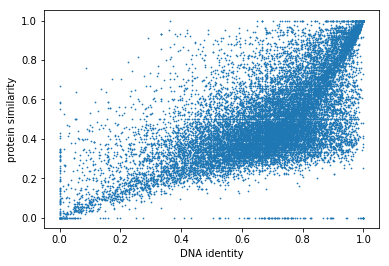

In [261]:
plt.scatter(x=single_DNA_score_table, y=single_identity_score_table, s= .5)
plt.xlabel('DNA identity')
plt.ylabel('protein similarity')
plt.show()

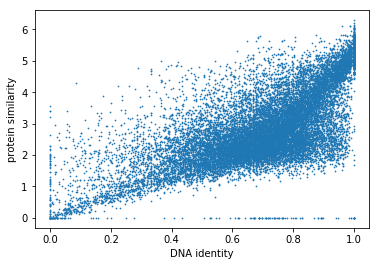

In [263]:
plt.scatter(x=single_DNA_score_table, y=single_blosum62_score_table, s= .5)
plt.xlabel('DNA identity')
plt.ylabel('protein similarity')
plt.show()

In [98]:
single_DNA_score_table = (DNAidentity_score_table
    .dropna(how='all', axis='rows')
    .reset_index(['EBZid', 'midid'])
    .sort_values(by='midid', ascending=True)
    .drop_duplicates(subset='EBZid', keep='first')

    .sort_values(by='EBZid')
    .set_index(['EBZid', 'midid'], append=True))

In [93]:
single_blosum62_score_table = pd.read_pickle('~/temp/single_blosum62.pandas.pic.gz')

single_stop_score_table = pd.read_pickle('~/temp/single_stop.pandas.pic.gz')
single_identity_score_table = pd.read_pickle('~/temp/single_identity.pandas.pic.gz')
monophyletic = pd.read_pickle('~/temp/monophyletic.pandas.pic.gz')
furthest= pd.read_pickle('~/temp/furthest.pandas.pic.gz')